<a href="https://colab.research.google.com/github/BDouchet/Spotify_dataset/blob/main/genre_classification/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='16phKfXvRrwGbOJrNKpgbYnBnZG6icXFX'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('dataset.zip')

with ZipFile('dataset.zip', 'r') as zip:
   zip.extractall()
   print('Done')

df=pd.read_csv('dataset/Spotify_train_dataset.csv')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data=df.drop(labels=['type','id','uri','track_href','analysis_url','song_name'],axis=1)

genres=['Dark Trap', 'Underground Rap', 'Trap Metal', 'Emo', 'Rap', 'RnB', 'Pop', 'Hiphop', 'techhouse', 'techno',
'trance', 'psytrance', 'trap', 'dnb', 'hardstyle']

le = LabelEncoder()
le.classes_=genres
data['genre']=le.transform(data['genre'])

X=data[data.columns[:-1]].to_numpy()
Y=data['genre'].to_numpy()

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=10,test_size=0.2)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

Done
(25382, 13) (25382,) (6346, 13) (6346,)


# Create and train Neural Networks

For this part, we will use Keras to implement and test our neural networks.

To get better performances, it is necessary to standardize our input values. 

The labels have to be one-hot encoded : 
````
class 1 between 3 classes :
[1] -> [0,1,0]
````

Thus, it is necessary to create the reverse operation o the one-hot encoding.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [ ]:
ss=StandardScaler()

x_train=ss.fit_transform(X_train)
x_test=ss.fit_transform(X_test)

y_train=tf.keras.utils.to_categorical(Y_train)
y_test=tf.keras.utils.to_categorical(Y_test)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(25382, 13) (6346, 13) (25382, 15) (6346, 15)


In [ ]:
# Reverse of the one-hot encoding
def to_labels(Y):
    return np.array([np.argmax(y) for y in Y ])

## NN1

*  4 layers : 64 -> 64 -> 64 -> 15
*  BatchNormalization
*  Dropout = 0.0
*  Number of Parameters : 10,959
*  Epochs = 30


In [ ]:
nn=models.Sequential()

nn.add(layers.Dense(64,activation='relu',input_shape=(13,)))
nn.add(layers.BatchNormalization())

nn.add(layers.Dense(64,activation='relu'))
nn.add(layers.BatchNormalization())

nn.add(layers.Dense(64,activation='relu'))
nn.add(layers.BatchNormalization())

nn.add(layers.Dense(15,activation='softmax'))

nn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 64)                256       
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
_________________________________________________________________
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_20 (Batc (None, 64)                256       
_________________________________________________________________
dense_28 (Dense)             (None, 15)               

In [ ]:
nn.compile(optimizer='Adam',metrics=['acc'],loss='categorical_crossentropy')
history=nn.fit(x_train,y_train,epochs=30,batch_size=128,validation_data=(x_test,y_test),verbose=2)

Epoch 1/30
199/199 - 2s - loss: 1.5643 - acc: 0.4955 - val_loss: 1.3321 - val_acc: 0.5769
Epoch 2/30
199/199 - 1s - loss: 1.1416 - acc: 0.6089 - val_loss: 1.0830 - val_acc: 0.6232
Epoch 3/30
199/199 - 1s - loss: 1.0526 - acc: 0.6301 - val_loss: 1.0209 - val_acc: 0.6358
Epoch 4/30
199/199 - 1s - loss: 1.0132 - acc: 0.6425 - val_loss: 0.9934 - val_acc: 0.6436
Epoch 5/30
199/199 - 1s - loss: 0.9864 - acc: 0.6510 - val_loss: 0.9823 - val_acc: 0.6437
Epoch 6/30
199/199 - 1s - loss: 0.9687 - acc: 0.6532 - val_loss: 0.9641 - val_acc: 0.6491
Epoch 7/30
199/199 - 1s - loss: 0.9528 - acc: 0.6552 - val_loss: 0.9575 - val_acc: 0.6524
Epoch 8/30
199/199 - 1s - loss: 0.9457 - acc: 0.6613 - val_loss: 0.9411 - val_acc: 0.6592
Epoch 9/30
199/199 - 1s - loss: 0.9324 - acc: 0.6630 - val_loss: 0.9367 - val_acc: 0.6620
Epoch 10/30
199/199 - 1s - loss: 0.9224 - acc: 0.6650 - val_loss: 0.9431 - val_acc: 0.6585
Epoch 11/30
199/199 - 1s - loss: 0.9162 - acc: 0.6672 - val_loss: 0.9308 - val_acc: 0.6639
Epoch 12

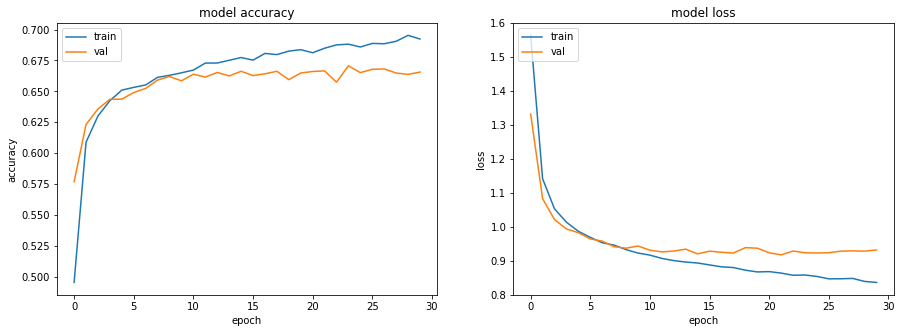

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
yhat_test=nn.predict(x_test)
yhat_train=nn.predict(x_train)



print(f1_score(Y_train,to_labels(yhat_train),average='micro'))
print(f1_score(Y_test,to_labels(yhat_test),average='micro'))

0.7153888582460011
0.6656161361487551


## NN2

*  6 layers : 64 -> 128 -> 256 -> 128 -> 64 -> 15
*  BatchNormalization
*  Dropout = 0.2
*  Number of Parameters : 86,927
*  Epochs = 100

In [ ]:
nn2=models.Sequential()

nn2.add(layers.Dense(64,activation='relu',input_shape=(13,)))
nn2.add(layers.BatchNormalization())

nn2.add(layers.Dense(128,activation='relu'))
nn2.add(layers.BatchNormalization())
nn2.add(layers.Dropout(0.2))

nn2.add(layers.Dense(256,activation='relu'))
nn2.add(layers.BatchNormalization())
nn2.add(layers.Dropout(0.2))

nn2.add(layers.Dense(128,activation='relu',input_shape=(13,)))
nn2.add(layers.BatchNormalization())
nn2.add(layers.Dropout(0.2))

nn2.add(layers.Dense(64,activation='relu'))
nn2.add(layers.BatchNormalization())
nn2.add(layers.Dropout(0.2))

nn2.add(layers.Dense(15,activation='softmax'))

nn2.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 64)                896       
_________________________________________________________________
batch_normalization_55 (Batc (None, 64)                256       
_________________________________________________________________
dense_98 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_56 (Batc (None, 128)               512       
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_57 (Batc (None, 256)             

In [ ]:
nn2.compile(optimizer='Adam',metrics=['acc'],loss='categorical_crossentropy')
history2=nn2.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_test,y_test),verbose=2)

Epoch 1/100
199/199 - 3s - loss: 1.7515 - acc: 0.4364 - val_loss: 1.2659 - val_acc: 0.5797
Epoch 2/100
199/199 - 2s - loss: 1.2791 - acc: 0.5595 - val_loss: 1.0587 - val_acc: 0.6287
Epoch 3/100
199/199 - 2s - loss: 1.1792 - acc: 0.5891 - val_loss: 1.0225 - val_acc: 0.6368
Epoch 4/100
199/199 - 2s - loss: 1.1232 - acc: 0.6109 - val_loss: 0.9938 - val_acc: 0.6417
Epoch 5/100
199/199 - 2s - loss: 1.0941 - acc: 0.6172 - val_loss: 0.9771 - val_acc: 0.6486
Epoch 6/100
199/199 - 2s - loss: 1.0701 - acc: 0.6218 - val_loss: 0.9669 - val_acc: 0.6540
Epoch 7/100
199/199 - 2s - loss: 1.0575 - acc: 0.6252 - val_loss: 0.9544 - val_acc: 0.6599
Epoch 8/100
199/199 - 2s - loss: 1.0445 - acc: 0.6283 - val_loss: 0.9392 - val_acc: 0.6595
Epoch 9/100
199/199 - 2s - loss: 1.0297 - acc: 0.6339 - val_loss: 0.9359 - val_acc: 0.6612
Epoch 10/100
199/199 - 2s - loss: 1.0206 - acc: 0.6395 - val_loss: 0.9386 - val_acc: 0.6582
Epoch 11/100
199/199 - 2s - loss: 1.0065 - acc: 0.6423 - val_loss: 0.9238 - val_acc: 0.66

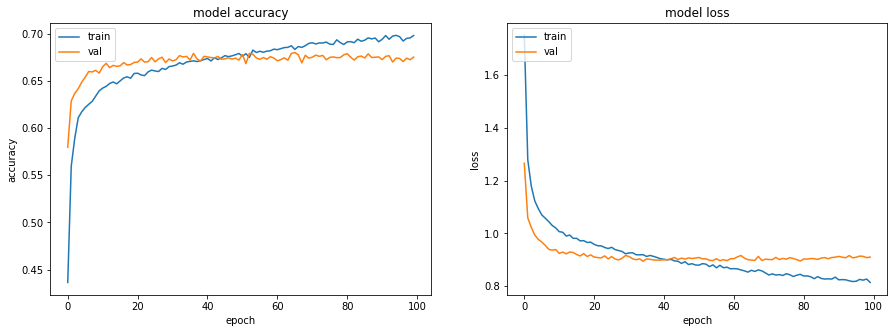

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history2.history['acc'])
ax1.plot(history2.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
yhat_test=nn2.predict(x_test)
yhat_train=nn2.predict(x_train)

print(f1_score(Y_train,to_labels(yhat_train),average='micro'))
print(f1_score(Y_test,to_labels(yhat_test),average='micro'))

0.7456859191553069
0.6752284903876458


## NN3

*  4 layers : 32 -> 64 -> 32 -> 15
*  Number of Parameters : 5,135
*  Epochs = 60

In [ ]:
nn3=models.Sequential()

nn3.add(layers.Dense(32,activation='relu',input_shape=(13,)))
nn3.add(layers.Dense(64,activation='relu'))
nn3.add(layers.Dense(32,activation='relu'))
nn3.add(layers.Dense(15,activation='softmax'))

nn3.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 32)                448       
_________________________________________________________________
dense_76 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_77 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_78 (Dense)             (None, 15)                495       
Total params: 5,135
Trainable params: 5,135
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn3.compile(optimizer='Adam',metrics=['acc'],loss='categorical_crossentropy')
history3=nn3.fit(x_train,y_train,epochs=60,batch_size=128,validation_data=(x_test,y_test),verbose=2)

Epoch 1/60
199/199 - 1s - loss: 1.8073 - acc: 0.4142 - val_loss: 1.3595 - val_acc: 0.5345
Epoch 2/60
199/199 - 1s - loss: 1.2786 - acc: 0.5604 - val_loss: 1.2080 - val_acc: 0.5878
Epoch 3/60
199/199 - 0s - loss: 1.1584 - acc: 0.5967 - val_loss: 1.1268 - val_acc: 0.6072
Epoch 4/60
199/199 - 0s - loss: 1.0847 - acc: 0.6190 - val_loss: 1.0650 - val_acc: 0.6303
Epoch 5/60
199/199 - 0s - loss: 1.0457 - acc: 0.6288 - val_loss: 1.0323 - val_acc: 0.6333
Epoch 6/60
199/199 - 0s - loss: 1.0212 - acc: 0.6349 - val_loss: 1.0118 - val_acc: 0.6368
Epoch 7/60
199/199 - 0s - loss: 1.0010 - acc: 0.6411 - val_loss: 1.0029 - val_acc: 0.6451
Epoch 8/60
199/199 - 0s - loss: 0.9880 - acc: 0.6453 - val_loss: 0.9948 - val_acc: 0.6407
Epoch 9/60
199/199 - 0s - loss: 0.9758 - acc: 0.6499 - val_loss: 0.9756 - val_acc: 0.6513
Epoch 10/60
199/199 - 0s - loss: 0.9682 - acc: 0.6505 - val_loss: 0.9761 - val_acc: 0.6502
Epoch 11/60
199/199 - 0s - loss: 0.9602 - acc: 0.6548 - val_loss: 0.9662 - val_acc: 0.6486
Epoch 12

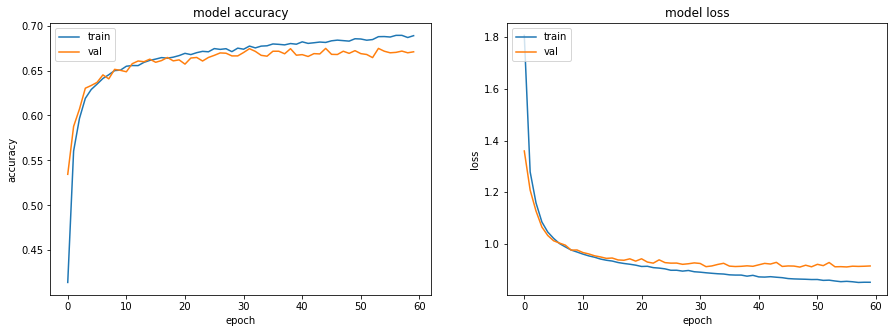

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history3.history['acc'])
ax1.plot(history3.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history3.history['loss'])
ax2.plot(history3.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
yhat_test=nn3.predict(x_test)
yhat_train=nn3.predict(x_train)

print(f1_score(Y_train,to_labels(yhat_train),average='micro'))
print(f1_score(Y_test,to_labels(yhat_test),average='micro'))

0.692695611062958
0.6708162622124173


## NN4

Same than NN2, with a different loss function : categorical_crossentropy -> weighted categroical_crossentropy

Because the dataset is not perfectly balanced, it is relevant to try to promote less frequent classes by increasing its penalties through the calculation of the loss.

The wieghts are defined as : $w_i=\frac{N}{N_i * c}$ with $N$ the total number of samples, $N_i$ the number of samples belonging to the class $i$ and $c$ the number of classes.

In [ ]:
nn4=models.Sequential()

nn4.add(layers.Dense(64,activation='relu',input_shape=(13,)))
nn4.add(layers.BatchNormalization())

nn4.add(layers.Dense(128,activation='relu'))
nn4.add(layers.BatchNormalization())
nn4.add(layers.Dropout(0.2))

nn4.add(layers.Dense(256,activation='relu'))
nn4.add(layers.BatchNormalization())
nn4.add(layers.Dropout(0.2))

nn4.add(layers.Dense(128,activation='relu',input_shape=(13,)))
nn4.add(layers.BatchNormalization())
nn4.add(layers.Dropout(0.2))

nn4.add(layers.Dense(64,activation='relu'))
nn4.add(layers.BatchNormalization())
nn4.add(layers.Dropout(0.2))

nn4.add(layers.Dense(15,activation='softmax'))

nn4.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 64)                896       
_________________________________________________________________
batch_normalization_64 (Batc (None, 64)                256       
_________________________________________________________________
dense_116 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_65 (Batc (None, 128)               512       
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_66 (Batc (None, 256)             

In [ ]:
from collections import Counter
count=Counter()
for genre in df['genre']:
    count.update([genre])
weights=[df.shape[0]/(count[genres[i]]*len(genres)) for i in range(len(genres))]

In [ ]:
weights

[0.6261693309650681,
 0.4831429876656007,
 1.4350067842605156,
 1.6760697305863708,
 1.4895774647887323,
 1.3178816199376948,
 6.295238095238095,
 0.9380044345898004,
 0.9384205856255545,
 0.9502246181491465,
 0.9297582417582417,
 0.9553748870822042,
 0.935929203539823,
 0.9558065973791233,
 0.9711662075298438]

In [ ]:
import tensorflow.keras.backend as K

def wcce(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        y_true=K.cast(y_true,dtype='float32')
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss

nn4.compile(optimizer='Adam',metrics=['acc'],loss=wcce(weights))
history4=nn4.fit(x_train,y_train,epochs=60,batch_size=128,validation_data=(x_test,y_test),verbose=2)

Epoch 1/60
199/199 - 3s - loss: 1.8490 - acc: 0.3939 - val_loss: 1.3802 - val_acc: 0.5421
Epoch 2/60
199/199 - 2s - loss: 1.3946 - acc: 0.5158 - val_loss: 1.1371 - val_acc: 0.5903
Epoch 3/60
199/199 - 2s - loss: 1.2820 - acc: 0.5521 - val_loss: 1.0796 - val_acc: 0.6105
Epoch 4/60
199/199 - 2s - loss: 1.2095 - acc: 0.5737 - val_loss: 1.0532 - val_acc: 0.6161
Epoch 5/60
199/199 - 2s - loss: 1.1740 - acc: 0.5738 - val_loss: 1.0283 - val_acc: 0.6152
Epoch 6/60
199/199 - 2s - loss: 1.1496 - acc: 0.5839 - val_loss: 1.0273 - val_acc: 0.6158
Epoch 7/60
199/199 - 2s - loss: 1.1350 - acc: 0.5877 - val_loss: 1.0083 - val_acc: 0.6259
Epoch 8/60
199/199 - 2s - loss: 1.1184 - acc: 0.5950 - val_loss: 1.0151 - val_acc: 0.6090
Epoch 9/60
199/199 - 2s - loss: 1.1006 - acc: 0.5956 - val_loss: 1.0163 - val_acc: 0.6155
Epoch 10/60
199/199 - 2s - loss: 1.0846 - acc: 0.5989 - val_loss: 0.9974 - val_acc: 0.6212
Epoch 11/60
199/199 - 2s - loss: 1.0787 - acc: 0.6005 - val_loss: 0.9972 - val_acc: 0.6291
Epoch 12

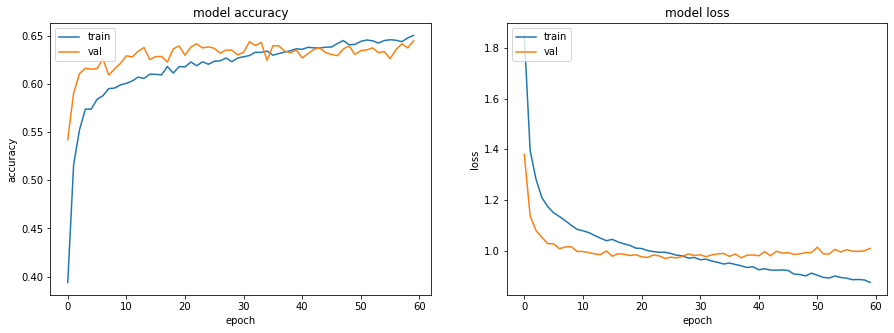

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history4.history['acc'])
ax1.plot(history4.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history4.history['loss'])
ax2.plot(history4.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
yhat_test=nn4.predict(x_test)
yhat_train=nn4.predict(x_train)

print(f1_score(Y_train,to_labels(yhat_train),average='micro'))
print(f1_score(Y_test,to_labels(yhat_test),average='micro'))

0.6923804270743046
0.6446580523164198
